# Курсовая работа
1. [Сборка датасета](#dataset_collect)
    1. [Коллокации](#collocations_collect) (для оценки качества)
    2. [Документы](#documents_collect)
2. [SyntaxNet](#syntaxnet)
    1. [Запуск SyntaxNet](#syntaxnet_run)
    2. [Обработка результатов SyntaxNet'а](#syntaxnet_postprocess)
    
    #### To be done...
3. Запуск TopMine
4. Запуск тематической модели
5. Обучение итоговой модели

In [2]:
import numpy as np

import nltk
from nltk.stem import WordNetLemmatizer
from pymystem3 import Mystem

from bs4 import BeautifulSoup
import re

import pandas as pd
import csv

import json
import os
import time

In [3]:
WIKI_XML = "../wiki.xml"
WIKIEXTRACTOR_FOLDER = "../wikiextractor/"
WIKITEXTS_JSON_FOLDER = "../wikitexts_json/"

WIKI_COLLECTION = "../collection/"
COLLOCS_FILE = "../collocs.txt"

SYNTAXNET_INPUT = "../sentences.txt"
SYNTAXNET_OUTPUT = "../syntaxnet_out.txt"

<a id='dataset_collect'></a>
# Сборка датасета

<a id='collocations_collect'></a>
## Коллокации

**Выделяем текст статьи из xml файла**

In [3]:
with open(WIKI_XML, "r") as f:
    data_xml = f.read().replace('\n', ' ')

In [4]:
soup = BeautifulSoup(data_xml, "xml")

In [5]:
texts = [tmp.text for tmp in soup.find_all('text')]

**Выделяем гиперссылки**

In [6]:
hyperlinks = []
for text in texts:
    for open_brackets, close_brackets in zip(re.finditer('\[\[', text), re.finditer('\]\]', text)):
        start_ind = open_brackets.span()[1]
        close_ind = close_brackets.span()[0]
        hyperlinks.append(text[start_ind:close_ind])

**Фильтруем теги, разбиваем ссылки с множественными словами**

In [7]:
filtered_hyperlinks = []
for hl in hyperlinks:
    # --- Теги ---
    # Игнорируем, если тег File:
    if re.match("File:", hl) and (re.match("File:", hl).span()[0] == 0):
        continue
    # Добавляем имя категории из тега Category:
    if re.match("Category:", hl) and (re.match("Category:", hl).span()[0] == 0):
        filtered_hyperlinks.append(hl[re.match("Category:", hl).span()[1]:])
        continue
    
    # --- НеТеги ---
    # Убираем все что в скобках
    hl = re.sub("\(.+\)", "", hl)
    # Разделяем мультиназвания (через | или and) на раздельные коллокации
    sub_hl = list(re.split("\|| and ", hl))
    
    filtered_hyperlinks += sub_hl

**Окончательная обработка, получаем коллокации**

In [8]:
collocs = []
for hl in filtered_hyperlinks:
    hl = hl.strip()
    hl = hl.lower()
    
    # Если это инициалы -> не добавляем
    if re.match("(.\. .\. .+)|(.+ .\. .+)", hl) and (len(hl.split(' ')) == 3):
        continue
        
    hl = re.sub(" +", " ", hl)
    hl = re.sub("[^ A-Za-z-]+", "", hl)
    hl = hl.strip()
    
    flag = (hl not in collocs) and \
           (len(hl.split(' ')) > 1) and \
           (len(hl.split(' ')) < 5)
    if flag:
        collocs.append(hl)

In [9]:
collocs

['computer scientist',
 'mikhail moiseevich bongard',
 'pattern recognition',
 'gdel escher bach',
 'douglas hofstadter',
 'harry foundalis',
 'fluid concepts',
 'creative analogies',
 'artificial intelligence',
 'machine learning',
 'cognitive science',
 'cognitive psychology',
 'computer-related introductions in',
 'statistical classification',
 'classification rule',
 'statistical model',
 'observable variable',
 'target variable',
 'joint probability distribution',
 'discriminative model',
 'conditional probability',
 'linear classifier',
 'naive bayes classifier',
 'linear discriminant analysis',
 'logistic regression',
 'support vector machine',
 'continuous variable',
 'discrete variable',
 'target function',
 'marginal distribution',
 'probability distribution',
 'bayes rule',
 'regression analysis',
 'gaussian mixture model',
 'mixture model',
 'hidden markov model',
 'stochastic context-free grammar',
 'probabilistic context-free grammar',
 'naive bayes',
 'averaged one-depen

**Записываем полученные коллокации в файл**

In [10]:
with open(COLLOCS_FILE, "w") as f:
    f.write('\n'.join(collocs))

**Статистика**

In [11]:
print("hyperlinks:\t{}".format(len(hyperlinks)))
print("filtered hl:\t{}".format(len(filtered_hyperlinks)))
print("collocations:\t{}".format(len(collocs)))

hyperlinks:	9200
filtered hl:	11375
collocations:	3651


<a id='documents_collect'></a>
## Документы

**Обрабатываем текст с помощью [wikiextractor](https://github.com/attardi/wikiextractor). Получаем json файлы**

In [18]:
os.system(WIKIEXTRACTOR_FOLDER + "/WikiExtractor.py " + "--json " + "-o " + WIKITEXTS_JSON_FOLDER + " " + WIKI_XML)

0

**Читаем их**

In [19]:
texts_str = ""
for subdir in os.listdir(WIKITEXTS_JSON_FOLDER):
    for file in os.listdir(WIKITEXTS_JSON_FOLDER + "/" + subdir):
        with open(WIKITEXTS_JSON_FOLDER + subdir + "/" + file, "r") as f:
            texts_str += f.read()

In [20]:
texts = []
for text in texts_str.split('\n'):
    if text != '':  # in case of double \n
        texts.append(json.loads(text))

**Сохраняем полученные документы в коллекцию + миниобработка**

In [31]:
for text in texts:
    filename = text["title"]
    filename = re.sub("[^A-Za-zА-Яа-я0-9 ]", "", filename)
    filename = re.sub(" +", "_", filename)
    article = '\n'.join(text["text"].split('\n')[2:])  # remove name of article at the start
    with open(WIKI_COLLECTION + filename + ".txt", "w") as f:
        f.write(article)

<a id='syntaxnet'></a>
# SyntaxNet

<a id='syntaxnet_run'></a>
## Запуск SyntaxNet

**Загружаем коллекцию, удаляем пунктуацию и переводим в нижний регистр. Получаем список предложений**

In [69]:
sentences = []

for doc_id, filename in enumerate(os.listdir(WIKI_COLLECTION)):
    with open(WIKI_COLLECTION + filename, "r") as f:
        sentences_raw = f.read().split('.')
    
    for sentence in sentences_raw:
        sentence_nopunct = re.sub("[^A-Za-zА-Яа-я ]", '', sentence)
        sentence_nopunct = sentence_nopunct.lower().strip()
        if len(sentence_nopunct) > 1:
            sentences.append(sentence_nopunct)

**Запишем в файл каждое предложение в отдельной строке**

In [70]:
with open(SYNTAXNET_INPUT, "w") as f:
    for sentence in sentences:
        f.write("{}\n".format(sentence))

**Прогоняем полученный файл через SyntaxNet** (docker взял [здесь](https://hub.docker.com/r/inemo/syntaxnet_eng/))

In [78]:
start_time = time.time()
if os.system("./run_syntaxnet.sh {} {}".format(SYNTAXNET_INPUT, SYNTAXNET_OUTPUT)) != 0:
    print("Something was wrong")
print("Done! It took {:.2f} s.".format(time.time() - start_time))

Done! It took 508.83 s.


Выход syntaxnet'а

In [4]:
syntaxnet_out = pd.read_table(SYNTAXNET_OUTPUT, header=None,
                              dtype={0: np.int, 6: np.int},
                              quoting=csv.QUOTE_NONE, engine='c'
                             )[[0, 1, 3, 6, 7]].fillna("")

In [5]:
syntaxnet_out.head()

,0,1,3,6,7
0,1,in,ADP,2,case
1,2,machine,NOUN,3,nmod
2,3,learning,VERB,10,csubj
3,4,the,DET,6,det
4,5,kernel,NOUN,6,compound


---

** !!! Это может пригодиться, но я пока это не использую **<br>
[Пропустить](#label1)

**К каждому слову добавим id предложения и его лемму**

In [6]:
syntaxnet_out = pd.read_table(SYNTAXNET_OUTPUT, header=None,
                              dtype={0: np.int, 6: np.int},
                              quoting=csv.QUOTE_NONE, engine='c'
                             )[[0, 1, 3, 6, 7]].fillna("")


lemmatizer = WordNetLemmatizer()

syntaxnet_out.columns = [["word_id", "word", "POS",
                          "parent_id", "dependency"]]

syntaxnet_out["word_id"] -= 1
syntaxnet_out["parent_id"] -= 1

cur_sentence_id = -1
sentence_ids = []
lemmas = []

for word_id, word, pos in zip(syntaxnet_out["word_id"],
                              syntaxnet_out["word"],
                              syntaxnet_out["POS"]):
    if word_id == 0:
        cur_sentence_id += 1
        
    if pos == "VERB":
        lemma = lemmatizer.lemmatize(word, pos='v')
    elif pos == "ADJ":
        lemma = lemmatizer.lemmatize(word, pos='a')
    elif pos == "ADV":
        lemma = lemmatizer.lemmatize(word, pos='r')
    else:
        lemma = lemmatizer.lemmatize(word, pos='n')
        
    lemmas.append(lemma)
    sentence_ids.append(cur_sentence_id)

syntaxnet_out["sentence_id"] = sentence_ids
syntaxnet_out["lemma"] = lemmas

In [7]:
syntaxnet_out.head()

,word_id,word,POS,parent_id,dependency,sentence_id,lemma
0,0,in,ADP,1,case,0,in
1,1,machine,NOUN,2,nmod,0,machine
2,2,learning,VERB,9,csubj,0,learn
3,3,the,DET,5,det,0,the
4,4,kernel,NOUN,5,compound,0,kernel


---
<a id="label1"></a>

<a id="syntaxnet_postprocess"></a>
## Обработка результатов SyntaxNet'а

**Открываем выход syntaxnet'а и составляем список деревьев**

In [8]:
with open(SYNTAXNET_OUTPUT, "r") as f:
    syntaxnet_out = f.read()

In [12]:
# May be removed
with open(SYNTAXNET_INPUT, "r") as f:
    sentences = f.read().split("\n")

In [9]:
processed_sentences = []
sentence = []
for line in syntaxnet_out.split("\n"):
    if len(line) == 0:
        processed_sentences.append(sentence)
        sentence = []
    else:
        word = line.split("\t")
        sentence.append(word)

In [81]:
deps = []
for sentence in processed_sentences:
    s = ''
    for line in sentence:
        s += "\t".join(line) + '\n'
    deps.append(s)
del deps[-1] # empty sentence

hsic can be extended to measure the dependence of multiple random variables


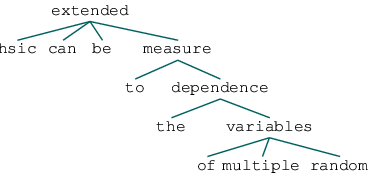

In [82]:
# Example
sent_dep = deps[50]
graph = nltk.DependencyGraph(tree_str=sent_dep)
tree = graph.tree()
print(sentences[50])
tree

** Выделим ветки деревьев **<br>
Позже можно будет использовать другие признаки, например находятся ли слова в одном поддереве

In [83]:
def get_branches(tree):
    def _get_branches(subtree, subbranches):
        subbranches *= len(subtree)
        for i, node in enumerate(subtree):
            if isinstance(node, str):
                subbranches[i] += (' ' + node)
            if isinstance(node, nltk.tree.Tree):
                subsubbranches = _get_branches(node, [subbranches[i] + ' ' + node.label()])
                del subbranches[i]
                subbranches[i:i] = subsubbranches
        return subbranches
    
    branches = [t.label()]
    return _get_branches(tree, branches)

In [85]:
syntax_branches = []
for sent_dep in deps:
    graph = nltk.DependencyGraph(tree_str=sent_dep)
    tree = graph.tree()
    syntax_branches += get_branches(tree)

In [90]:
syntax_branches[40:45]

# Example: feature datapoint

['extended generalization mapping the all features distributions of',
 'extended generalization mapping the all features distributions arbitrary',
 'extended generalization mapping individual',
 'extended generalization mapping feature datapoint',
 'extended generalization mapping done methods in']